In [1]:
## perform imports and set-up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d
from patsy.contrasts import Treatment

import torch
from torch.nn import Module
from torch import nn
# import torchvision
# from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
# import torchvision.transforms as transforms

from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.decomposition import IncrementalPCA
from sklearn.cross_decomposition import PLSRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.datasets import make_regression

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet

import random
import csv

from datetime import datetime
from dateutil.relativedelta import relativedelta

from diebold_mariano_test import *

%matplotlib inline
plt.style.use('ggplot') # emulate pretty r-style plots

In [2]:
def read_file(file_path, nrows=None):
    # Sample 100 rows of data to determine dtypes.
    df_test = pd.read_csv(file_path, nrows=100)
    float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
    float16_cols = {c: np.float16 for c in float_cols}
    df = pd.read_csv(file_path, engine='c', dtype=float16_cols, nrows=nrows)
    return df

In [3]:
data = read_file('test_data.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
character_names = pd.read_csv('character_names.csv')['character_names'].values
macropredictors_names = np.array(["d_p", "e_p", "b_m", "ntis", "tbl", "tms", "dfy", "svar"])
macropredictors_names = np.array(['dp', 'ep', 'bm', 'ntis', 'tbl', 'tms', 'dfy', 'svar'])
all_names = np.append(character_names, macropredictors_names)

# data = read_file('data_manipulated.csv').iloc[:,1:]
# macropredictors = pd.read_csv("macropredictors.csv")
# data = read_file('./datashare/GKX_20201231.csv')
# macropredictors_raw = pd.read_excel('PredictorData2021.xlsx')

In [15]:
character_names.shape, macropredictors_names.shape, all_names.shape # macro_character_names.shape, 

((94,), (8,), (75,), (177,))

## Calculate out-of-sample performance

In [315]:
model_res_name = ["OLS_result", "OLS-3_result", "PLS_result", "PCR_result", 
            "ENet_result", 
            "RF_result", 
            "GBRT_result", 
            "L1_NN_result", "L2_NN_result", "L3_NN_result",
            "L4_NN_result", "L5_NN_result"]

In [316]:
model_name = ["OLS", "OLS-3", "PLS", "PCR", 
            "ENet", 
            "RF", 
            "GBRT", 
            "NN1", "NN2", "NN3",
            "NN4", "NN5"]

In [24]:
result_file = [c+'.csv' for c in model_res_name]
# result_vi_file = ['result/'+c+'_vi.csv' for c in model_res_name]
# result_file, result_vi_file

In [161]:
all_roos = []
# model_res_name
for idx,file in enumerate(result_file):
    run_data = pd.read_csv(file, header=None)
    se = np.sum((run_data.iloc[:,0] - run_data.iloc[:,1])**2)
    denominator = np.sum(run_data.iloc[:,1]**2)
    roos = 1 - se/denominator
    all_roos.append(roos)
    print(model_res_name[idx] + ':', roos)


OLS_result: -0.07940798737289678
OLS-3_result: -0.0001235164462822791
PLS_result: -0.008298951544227329
PCR_result: 0.002897052758083052
ENet_result: 0.0011997367065893494
RF_result: 0.0024338373063378382
GBRT_result: -0.000994194034912077
L1_NN_result: -0.002039044714423399
L2_NN_result: 0.0018486263806924974
L3_NN_result: 0.002820694969501991
L4_NN_result: 0.0027947810418862407
L5_NN_result: 0.0027639608684250083


In [149]:
stock, stock_count = np.unique(data['permno'], return_counts=True)
# data['mvel1']
stock_equity = []
for item in stock:
    temp = np.mean(data.loc[data['permno'] == item, 'mvel1'])
    stock_equity.append(temp)

In [150]:
stock_equity = np.array(stock_equity)
idx = np.argsort(stock_equity)
top_stock_1000 = stock[idx][-1000:]
bottom_stock_1000 = stock[idx][:1000]

In [151]:
test_start = datetime.strptime("1987-01-01", "%Y-%m-%d")
test_end = datetime.strptime("2016-12-31", "%Y-%m-%d")
test_index = (data['DATE'] >= test_start) & (data['DATE'] <= test_end)

top_idx_1000 = data[test_index]['permno'].isin(top_stock_1000)

top_roos = []
# model_res_name
for idx,file in enumerate(result_file):
    run_data = pd.read_csv(file, header=None)
    se = np.sum((run_data[top_idx_1000.values].iloc[:,0] - run_data[top_idx_1000.values].iloc[:,1])**2)
    denominator = np.sum(run_data[top_idx_1000.values].iloc[:,1]**2)
    roos = 1 - se/denominator
    top_roos.append(roos)
    print(model_res_name[idx] + ':', roos)

OLS_result: -0.31530199633135725
OLS-3_result: 0.012311599464554845
PLS_result: -0.04459974972548997
PCR_result: 0.015277217299696555
ENet_result: 0.005078936162203673
RF_result: 0.012022834187464193
GBRT_result: -0.006152175959329043
L1_NN_result: -0.006805093413748686
L2_NN_result: 0.007908456049924295
L3_NN_result: 0.017260954991725197
L4_NN_result: 0.017959134781258546
L5_NN_result: 0.017677334970291225


In [152]:
bottom_idx_1000 = data[test_index]['permno'].isin(bottom_stock_1000)
bottom_roos = []
# model_res_name
for idx,file in enumerate(result_file):
    run_data = pd.read_csv(file, header=None)
    se = np.sum((run_data[bottom_idx_1000.values].iloc[:,0] - run_data[bottom_idx_1000.values].iloc[:,1])**2)
    denominator = np.sum(run_data[bottom_idx_1000.values].iloc[:,1]**2)
    roos = 1 - se/denominator
    bottom_roos.append(roos)
    print(model_res_name[idx] + ':', roos)

OLS_result: -0.05288797135916168
OLS-3_result: -0.0003454539324421191
PLS_result: -0.004001901419027787
PCR_result: -0.0019561431565293663
ENet_result: -0.00018915173918809813
RF_result: -0.0012870129201685288
GBRT_result: -0.0018662500450179476
L1_NN_result: -0.0014354275877634937
L2_NN_result: -0.0019158296311965195
L3_NN_result: -0.0019504994221559713
L4_NN_result: -0.001998409293917369
L5_NN_result: -0.0019774438616575463


In [172]:
# df = pd.DataFrame({'All':all_roos, 'Top':top_roos, 'Bottom':bottom_roos, 'Method':model_name})

In [237]:
model_name = ["OLS-3+H", "PLS", "PCR", "ENet+H", 
            "RF", 
            "GBRT+H", 
            "NN1", "NN2", "NN3", "NN4", "NN5"]

In [314]:
pd.DataFrame({'All':all_roos, 'Top':top_roos, 'Bottom':bottom_roos}).round(4)*100

,All,Top,Bottom
0,-7.94,-31.53,-5.29
1,-0.01,1.23,-0.03
2,-0.83,-4.46,-0.40
3,0.29,1.53,-0.20
4,0.12,0.51,-0.02
5,0.24,1.20,-0.13
6,-0.10,-0.62,-0.19
7,-0.20,-0.68,-0.14
8,0.18,0.79,-0.19
9,0.28,1.73,-0.20


In [157]:
np.concatenate([all_roos[1:], top_roos[1:], bottom_roos[1:]])

array([-0.00012352, -0.00829895,  0.00289705,  0.00119974,  0.00243384,
       -0.00099419, -0.00203904,  0.00184863,  0.00282069,  0.00279478,
        0.00276396,  0.0123116 , -0.04459975,  0.01527722,  0.00507894,
        0.01202283, -0.00615218, -0.00680509,  0.00790846,  0.01726095,
        0.01795913,  0.01767733, -0.00034545, -0.0040019 , -0.00195614,
       -0.00018915, -0.00128701, -0.00186625, -0.00143543, -0.00191583,
       -0.0019505 , -0.00199841, -0.00197744])

In [238]:
performance_name = ['All', 'Top', 'Bottom']
# put together all portfolios
df_dict = dict(    Roos=np.concatenate([all_roos[1:], top_roos[1:], bottom_roos[1:]])*100,
                   method=np.concatenate([model_name]*len(performance_name)),
                   portfolio=sum([len(model_name)*[name] for name in performance_name], []))
df = pd.DataFrame(df_dict) 

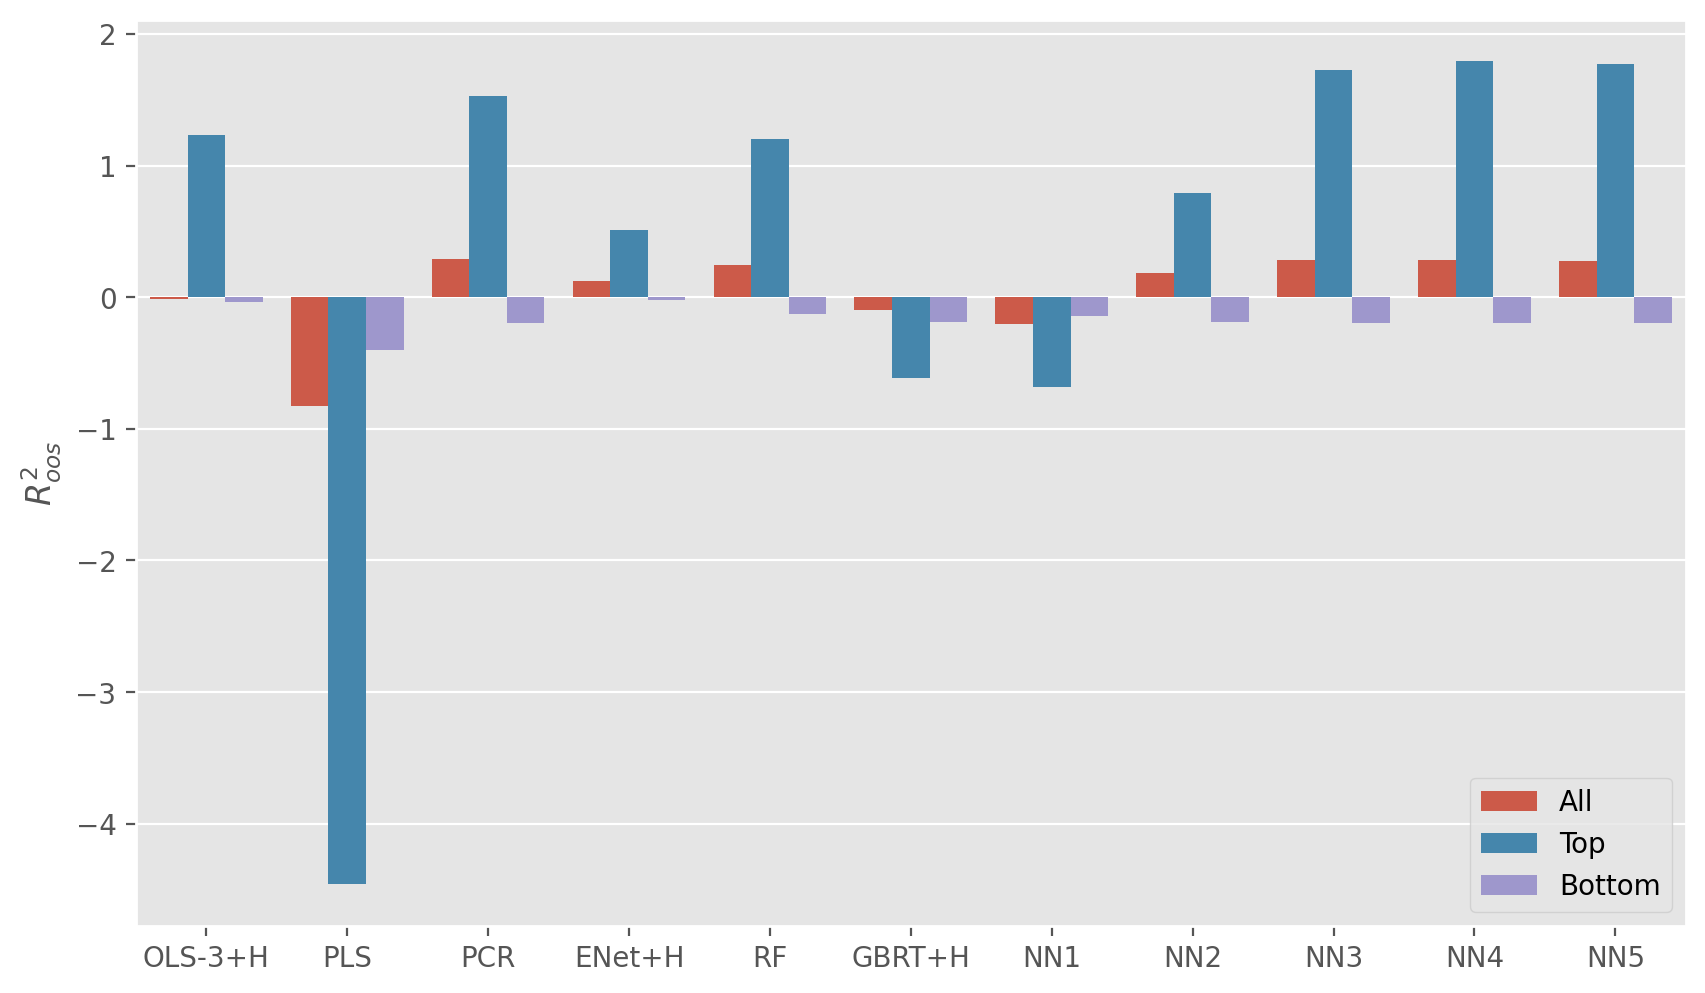

In [239]:
plt.figure(figsize=(10, 6), dpi=200)
p=sns.barplot(x = 'method',
            y = 'Roos',
            hue = 'portfolio',
            data = df)
p.set_ylabel("$R^2_{oos}$")#, fontsize = 20)
p.set_xlabel("")
# Show the plot
plt.legend(title="")
plt.savefig('result_1.pdf', format='pdf')
plt.show()

## Diebold-Mariano tests

In [317]:
# model_res_name = ["OLS_result", "OLS-3_result", "PLS_result", "PCR_result", 
#             "ENet_result", 
#             "RF_result", 
#             "GBRT_result", 
#             "L1_NN_result", "L2_NN_result", "L3_NN_result",
#             "L4_NN_result", "L5_NN_result"]

model_name = ["OLS+H", "OLS-3+H", "PLS", "PCR", "ENet+H", 
            "RF", 
            "GBRT+H", 
            "NN1", "NN2", "NN3", "NN4", "NN5"]

df = pd.read_csv('test_all.csv')
# result_file = [c+'.csv' for c in model_res_name]

# df = pd.DataFrame()

# # model_res_name
# for idx,file in enumerate(result_file):
#     run_data = pd.read_csv(file, header=None)
#     se = np.sum((run_data.iloc[:,0] - run_data.iloc[:,1])**2)
#     df['y_test'] = run_data.iloc[:,1]
#     df[model_name[idx]] = run_data.iloc[:,0]

In [96]:
# df.to_csv('test_all.csv', index=None)

In [79]:
# test_start = datetime.strptime("1987-01-01", "%Y-%m-%d")
# test_end = datetime.strptime("1987-12-31", "%Y-%m-%d") + relativedelta(years=29)
# test_index = (data['DATE'] >= test_start) & (data['DATE'] <= test_end)
# sum(test_index)
# df['DATE'] = data[test_index]['DATE'].values

In [95]:
# df['mvel1'] =  data[test_index]['mvel1'].values

In [98]:
# data.to_csv('test_data.csv', index=None)

In [99]:
# df['mvel1'] = data[test_index]['mvel1'].values

In [31]:
# date, date_count = np.unique(data[test_index]['DATE'], return_counts=True)
# stock, stock_count = np.unique(data[test_index]['permno'], return_counts=True)

In [318]:
from scipy import stats
from scipy.stats import sem
pval_thre = stats.t(df=359).ppf(0.95)
pval_thre

1.649109150019216

In [319]:
def cal_DM_test(df, y_pred1_name, y_pred2_name):
    d_t = []
    date, date_count = np.unique(df['DATE'], return_counts=True)
    for item in date:
        item_index = (df['DATE'] == item)
        error_sum = np.sum((df[item_index][y_pred1_name].values - df[item_index]['y_test'].values)**2) - np.sum((df[item_index][y_pred2_name].values - df[item_index]['y_test'].values)**2)
        error_sum = error_sum/sum(item_index)
        d_t.append(error_sum)
    return d_t

In [136]:
# temp = cal_DM_test(df, 'OLS-3+H', 'PCR')
# np.mean(temp)/sem(temp)

1.8388851066001068

In [137]:
DM_matrix_all = np.zeros(shape=(len(model_name),len(model_name)))
DM_test_df_all = pd.DataFrame()

In [324]:
def cal_mul_dm(model_name, df):
    DM_matrix = np.zeros(shape=(len(model_name),len(model_name)))
    DM_test_df = pd.DataFrame()
    for idx1,name1 in enumerate(model_name):
        for idx2,name2 in enumerate(model_name):
            if(idx2>=idx1):
                continue
            # perform DM test, the degree of model 1 performs better than model 2
            temp = cal_DM_test(df, name2, name1)
            print(name2+'_vs_'+name1)
            # print(temp)
            DM_test_df[name2+'_vs_'+name1] = temp
            DM_matrix[idx2,idx1] = np.mean(temp)/sem(temp)
            DM_matrix[idx1,idx2] = -DM_matrix[idx2,idx1]
            print(DM_matrix[idx2,idx1])
    return(DM_test_df, DM_matrix)


In [321]:
def cal_mul_dm(model_name, df):
    DM_matrix = np.zeros(shape=(len(model_name),len(model_name)))
    DM_test_df = pd.DataFrame()
    for idx1,name1 in enumerate(model_name):
        for idx2,name2 in enumerate(model_name):
            if(idx2==idx1):
                continue
            # perform DM test, the degree of model 1 performs better than model 2
            temp = cal_DM_test(df, name2, name1)
            print(name2+'_vs_'+name1)
            # print(temp)
            DM_test_df[name2+'_vs_'+name1] = temp
            DM_matrix[idx2,idx1] = np.mean(temp)/sem(temp)
            print(DM_matrix[idx2,idx1])
    return(DM_test_df, DM_matrix)

In [325]:
DM_test_df_all, DM_matrix_all = cal_mul_dm(model_name, df)

# DM_test_df_top, DM_matrix_top = cal_mul_dm(model_name, df[top_idx_1000.values])

# DM_test_df_bottom, DM_matrix_bottom = cal_mul_dm(model_name, df[bottom_idx_1000.values])

OLS+H_vs_OLS-3+H
8.079680040111493
OLS+H_vs_PLS
9.256572361017978
OLS-3+H_vs_PLS
-2.6718190161646587
OLS+H_vs_PCR
9.085516693859871
OLS-3+H_vs_PCR
1.8388851066001068
PLS_vs_PCR
3.9223701160978903
OLS+H_vs_ENet+H
8.264883006215193
OLS-3+H_vs_ENet+H
2.7880733290699773
PLS_vs_ENet+H
3.2107213950768947
PCR_vs_ENet+H
-1.2647647941762674
OLS+H_vs_RF
9.31087484473498
OLS-3+H_vs_RF
1.2034061301417343
PLS_vs_RF
3.847954739426685
PCR_vs_RF
-0.1982928970841594
ENet+H_vs_RF
0.6689936887127029
OLS+H_vs_GBRT+H
8.473916182645345
OLS-3+H_vs_GBRT+H
-0.34370711655358577
PLS_vs_GBRT+H
2.9016813846510727
PCR_vs_GBRT+H
-1.56486421325049
ENet+H_vs_GBRT+H
-1.109204759515789
RF_vs_GBRT+H
-1.4691498942845564
OLS+H_vs_NN1
8.730258783313213
OLS-3+H_vs_NN1
-0.7733272573800746
PLS_vs_NN1
2.2976385777650594
PCR_vs_NN1
-3.979280065563786
ENet+H_vs_NN1
-1.5928802230492052
RF_vs_NN1
-2.3018425941785714
GBRT+H_vs_NN1
-0.4111365244916005
OLS+H_vs_NN2
8.882944955221761
OLS-3+H_vs_NN2
1.2130509422634843
PLS_vs_NN2
3.48221

In [326]:
DM_test_df_all.to_csv('DM_test_all.csv', index=None)
pd.DataFrame(DM_matrix_all).round(2).to_csv('dm_result_all.csv', index=None, header=None)

# DM_test_df_top.to_csv('DM_test_top.csv', index=None)
# pd.DataFrame(DM_matrix_top).round(2).to_csv('dm_result_top.csv', index=None, header=None)

# DM_test_df_bottom.to_csv('DM_test_bottom.csv', index=None)
# pd.DataFrame(DM_matrix_bottom).round(2).to_csv('dm_result_bottom.csv', index=None, header=None)

## Calculate variable importance

In [328]:
model_res_name = [
            # "OLS_result", "OLS-3_result", 
            "PLS_result", "PCR_result", 
            "ENet_result", 
            "RF_result", 
            "GBRT_result"] 
            # "L1_NN_result", "L2_NN_result", "L3_NN_result",
            # "L4_NN_result", "L5_NN_result"]

model_name = [
            # "OLS+H", "OLS-3+H", 
            "PLS", "PCR", "ENet+H", 
            "RF", 
            "GBRT+H"]
            # "NN1", "NN2", "NN3", "NN4", "NN5"]

result_file = [c+'_vi.csv' for c in model_res_name]

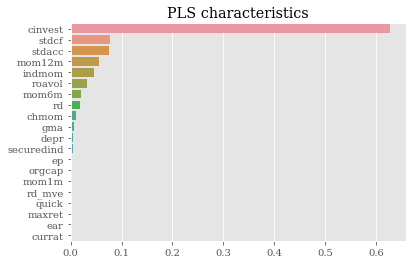

PLS_result_vi.csv
['cinvest' 'stdcf' 'stdacc' 'mom12m' 'indmom' 'roavol' 'mom6m' 'rd'
 'chmom' 'gma' 'depr' 'securedind' 'ep' 'orgcap' 'mom1m' 'rd_mve' 'quick'
 'maxret' 'ear' 'currat']
tensor([0.6269, 0.0768, 0.0751, 0.0547, 0.0452, 0.0318, 0.0197, 0.0176, 0.0097,
        0.0056, 0.0043, 0.0041, 0.0029, 0.0028, 0.0027, 0.0026, 0.0024, 0.0022,
        0.0017, 0.0017], dtype=torch.float64)


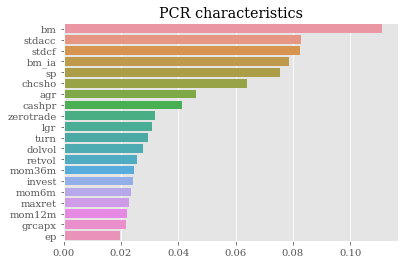

PCR_result_vi.csv
['bm' 'stdacc' 'stdcf' 'bm_ia' 'sp' 'chcsho' 'agr' 'cashpr' 'zerotrade'
 'lgr' 'turn' 'dolvol' 'retvol' 'mom36m' 'invest' 'mom6m' 'maxret'
 'mom12m' 'grcapx' 'ep']
tensor([0.1112, 0.0827, 0.0825, 0.0788, 0.0755, 0.0639, 0.0460, 0.0413, 0.0320,
        0.0309, 0.0294, 0.0276, 0.0256, 0.0246, 0.0244, 0.0235, 0.0229, 0.0220,
        0.0218, 0.0196], dtype=torch.float64)


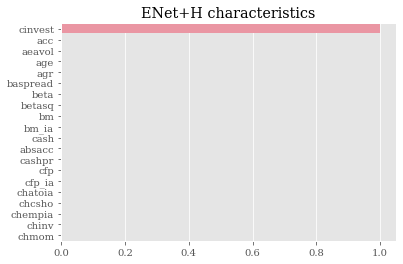

ENet_result_vi.csv
['cinvest' 'acc' 'aeavol' 'age' 'agr' 'baspread' 'beta' 'betasq' 'bm'
 'bm_ia' 'cash' 'absacc' 'cashpr' 'cfp' 'cfp_ia' 'chatoia' 'chcsho'
 'chempia' 'chinv' 'chmom']
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=torch.float64)


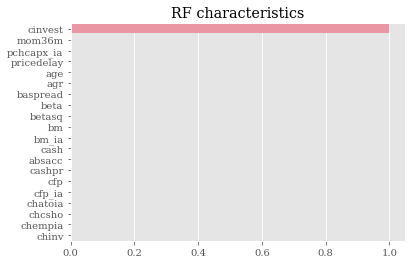

RF_result_vi.csv
['cinvest' 'mom36m' 'pchcapx_ia' 'pricedelay' 'age' 'agr' 'baspread'
 'beta' 'betasq' 'bm' 'bm_ia' 'cash' 'absacc' 'cashpr' 'cfp' 'cfp_ia'
 'chatoia' 'chcsho' 'chempia' 'chinv']
tensor([1.0000e+00, 3.9509e-15, 3.9509e-15, 3.9509e-15, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], dtype=torch.float64)


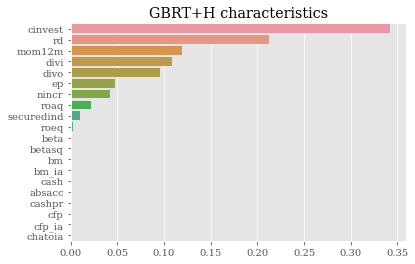

GBRT_result_vi.csv
['cinvest' 'rd' 'mom12m' 'divi' 'divo' 'ep' 'nincr' 'roaq' 'securedind'
 'roeq' 'beta' 'betasq' 'bm' 'bm_ia' 'cash' 'absacc' 'cashpr' 'cfp'
 'cfp_ia' 'chatoia']
tensor([0.3416, 0.2120, 0.1193, 0.1083, 0.0952, 0.0476, 0.0418, 0.0217, 0.0098,
        0.0026, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], dtype=torch.float64)


In [329]:
# model_res_name
for name_idx, file in enumerate(result_file):
    vi_data = pd.read_csv(file, header=None)
    vi = np.sum(vi_data, axis=0)[:94]
    vi[vi<0] = 0
    vi = vi/sum(vi)
    vi_value, idx = torch.topk(torch.tensor(vi), k=20, axis=-1)
    vi_name = character_names[idx]
    vi_df = pd.DataFrame({'characteristics':vi_name, 'value':vi_value})
    plt.title(model_name[name_idx]+' characteristics')
    ax = sns.barplot(x="value", y="characteristics", data=vi_df)
    ax.set_ylabel("")
    ax.set_xlabel("")
    plt.savefig(model_name[name_idx]+'_charac_vi.pdf', format="pdf")#, bbox_inches="tight")
    plt.show()
    print(file)
    print(vi_name)
    print(vi_value)


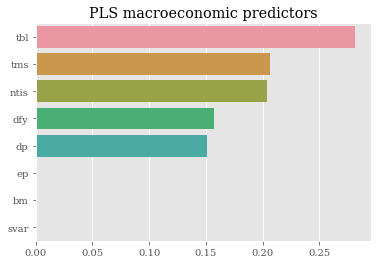

PLS_result_vi.csv
['tbl' 'tms' 'ntis' 'dfy' 'dp' 'ep' 'bm' 'svar']
tensor([0.2811, 0.2067, 0.2042, 0.1571, 0.1509, 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)


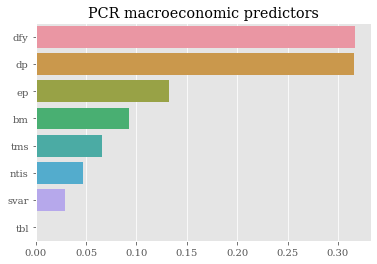

PCR_result_vi.csv
['dfy' 'dp' 'ep' 'bm' 'tms' 'ntis' 'svar' 'tbl']
tensor([0.3165, 0.3157, 0.1328, 0.0922, 0.0659, 0.0473, 0.0295, 0.0000],
       dtype=torch.float64)


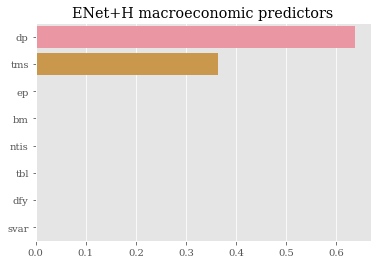

ENet_result_vi.csv
['dp' 'tms' 'ep' 'bm' 'ntis' 'tbl' 'dfy' 'svar']
tensor([0.6367, 0.3633, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)


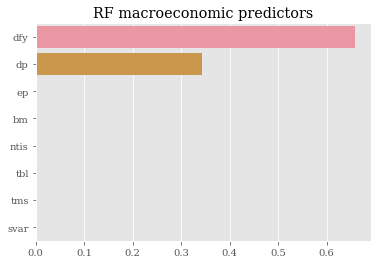

RF_result_vi.csv
['dfy' 'dp' 'ep' 'bm' 'ntis' 'tbl' 'tms' 'svar']
tensor([0.6577, 0.3423, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)


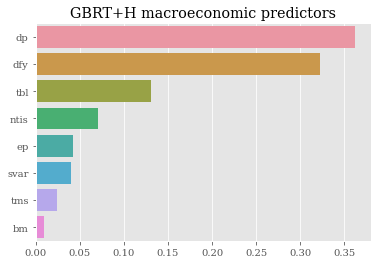

GBRT_result_vi.csv
['dp' 'dfy' 'tbl' 'ntis' 'ep' 'svar' 'tms' 'bm']
tensor([0.3615, 0.3226, 0.1305, 0.0703, 0.0423, 0.0395, 0.0238, 0.0096],
       dtype=torch.float64)


In [330]:
# model_res_name
for name_idx, file in enumerate(result_file):
    vi_data = pd.read_csv(file, header=None)
    vi = np.sum(vi_data, axis=0)[94:].values
    vi[vi<0] = 0
    vi = vi/sum(vi)
    vi_value, idx = torch.topk(torch.tensor(vi), k=8, axis=-1)
    vi_name = macropredictors_names[idx]
    vi_df = pd.DataFrame({'macro':vi_name, 'value':vi_value})
    plt.title(model_name[name_idx]+' macroeconomic predictors')
    ax = sns.barplot(x="value", y="macro", data=vi_df)
    ax.set_ylabel("")
    ax.set_xlabel("")
    plt.savefig(model_name[name_idx]+'_macro_vi.pdf', format="pdf")#, bbox_inches="tight")
    plt.show()
    print(file)
    print(vi_name)
    print(vi_value)

In [331]:
charac_df = pd.DataFrame()
# model_res_name
for name_idx, file in enumerate(result_file):
    vi_data = pd.read_csv(file, header=None)
    vi = np.sum(vi_data, axis=0)[:94].values
    vi[vi<0] = 0
    vi = vi/sum(vi)
    charac_df[model_name[name_idx]] = vi

In [332]:
charac_df

,PLS,PCR,ENet+H,RF,GBRT+H
0,0.000000,0.000000,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0
2,0.000332,0.000000,0.0,0.0,0.0
3,0.000000,0.004309,0.0,0.0,0.0
4,0.000000,0.046027,0.0,0.0,0.0
...,...,...,...,...,...
89,0.076807,0.082516,0.0,0.0,0.0
90,0.000098,0.000000,0.0,0.0,0.0
91,0.000000,0.000000,0.0,0.0,0.0
92,0.000000,0.029390,0.0,0.0,0.0


In [333]:
from scipy.stats import rankdata
charac_rank = pd.DataFrame()
for name in model_name:
    charac_rank[name] = rankdata(charac_df[name])

In [334]:
sum_vi = np.sum(charac_df, axis=1)
vi_value, idx = torch.topk(torch.tensor(sum_vi), k=94, axis=-1)
charac_rank.loc[idx], character_names[idx]
charac_rank['name'] = character_names
charac_rank.set_index(['name'], inplace=True)

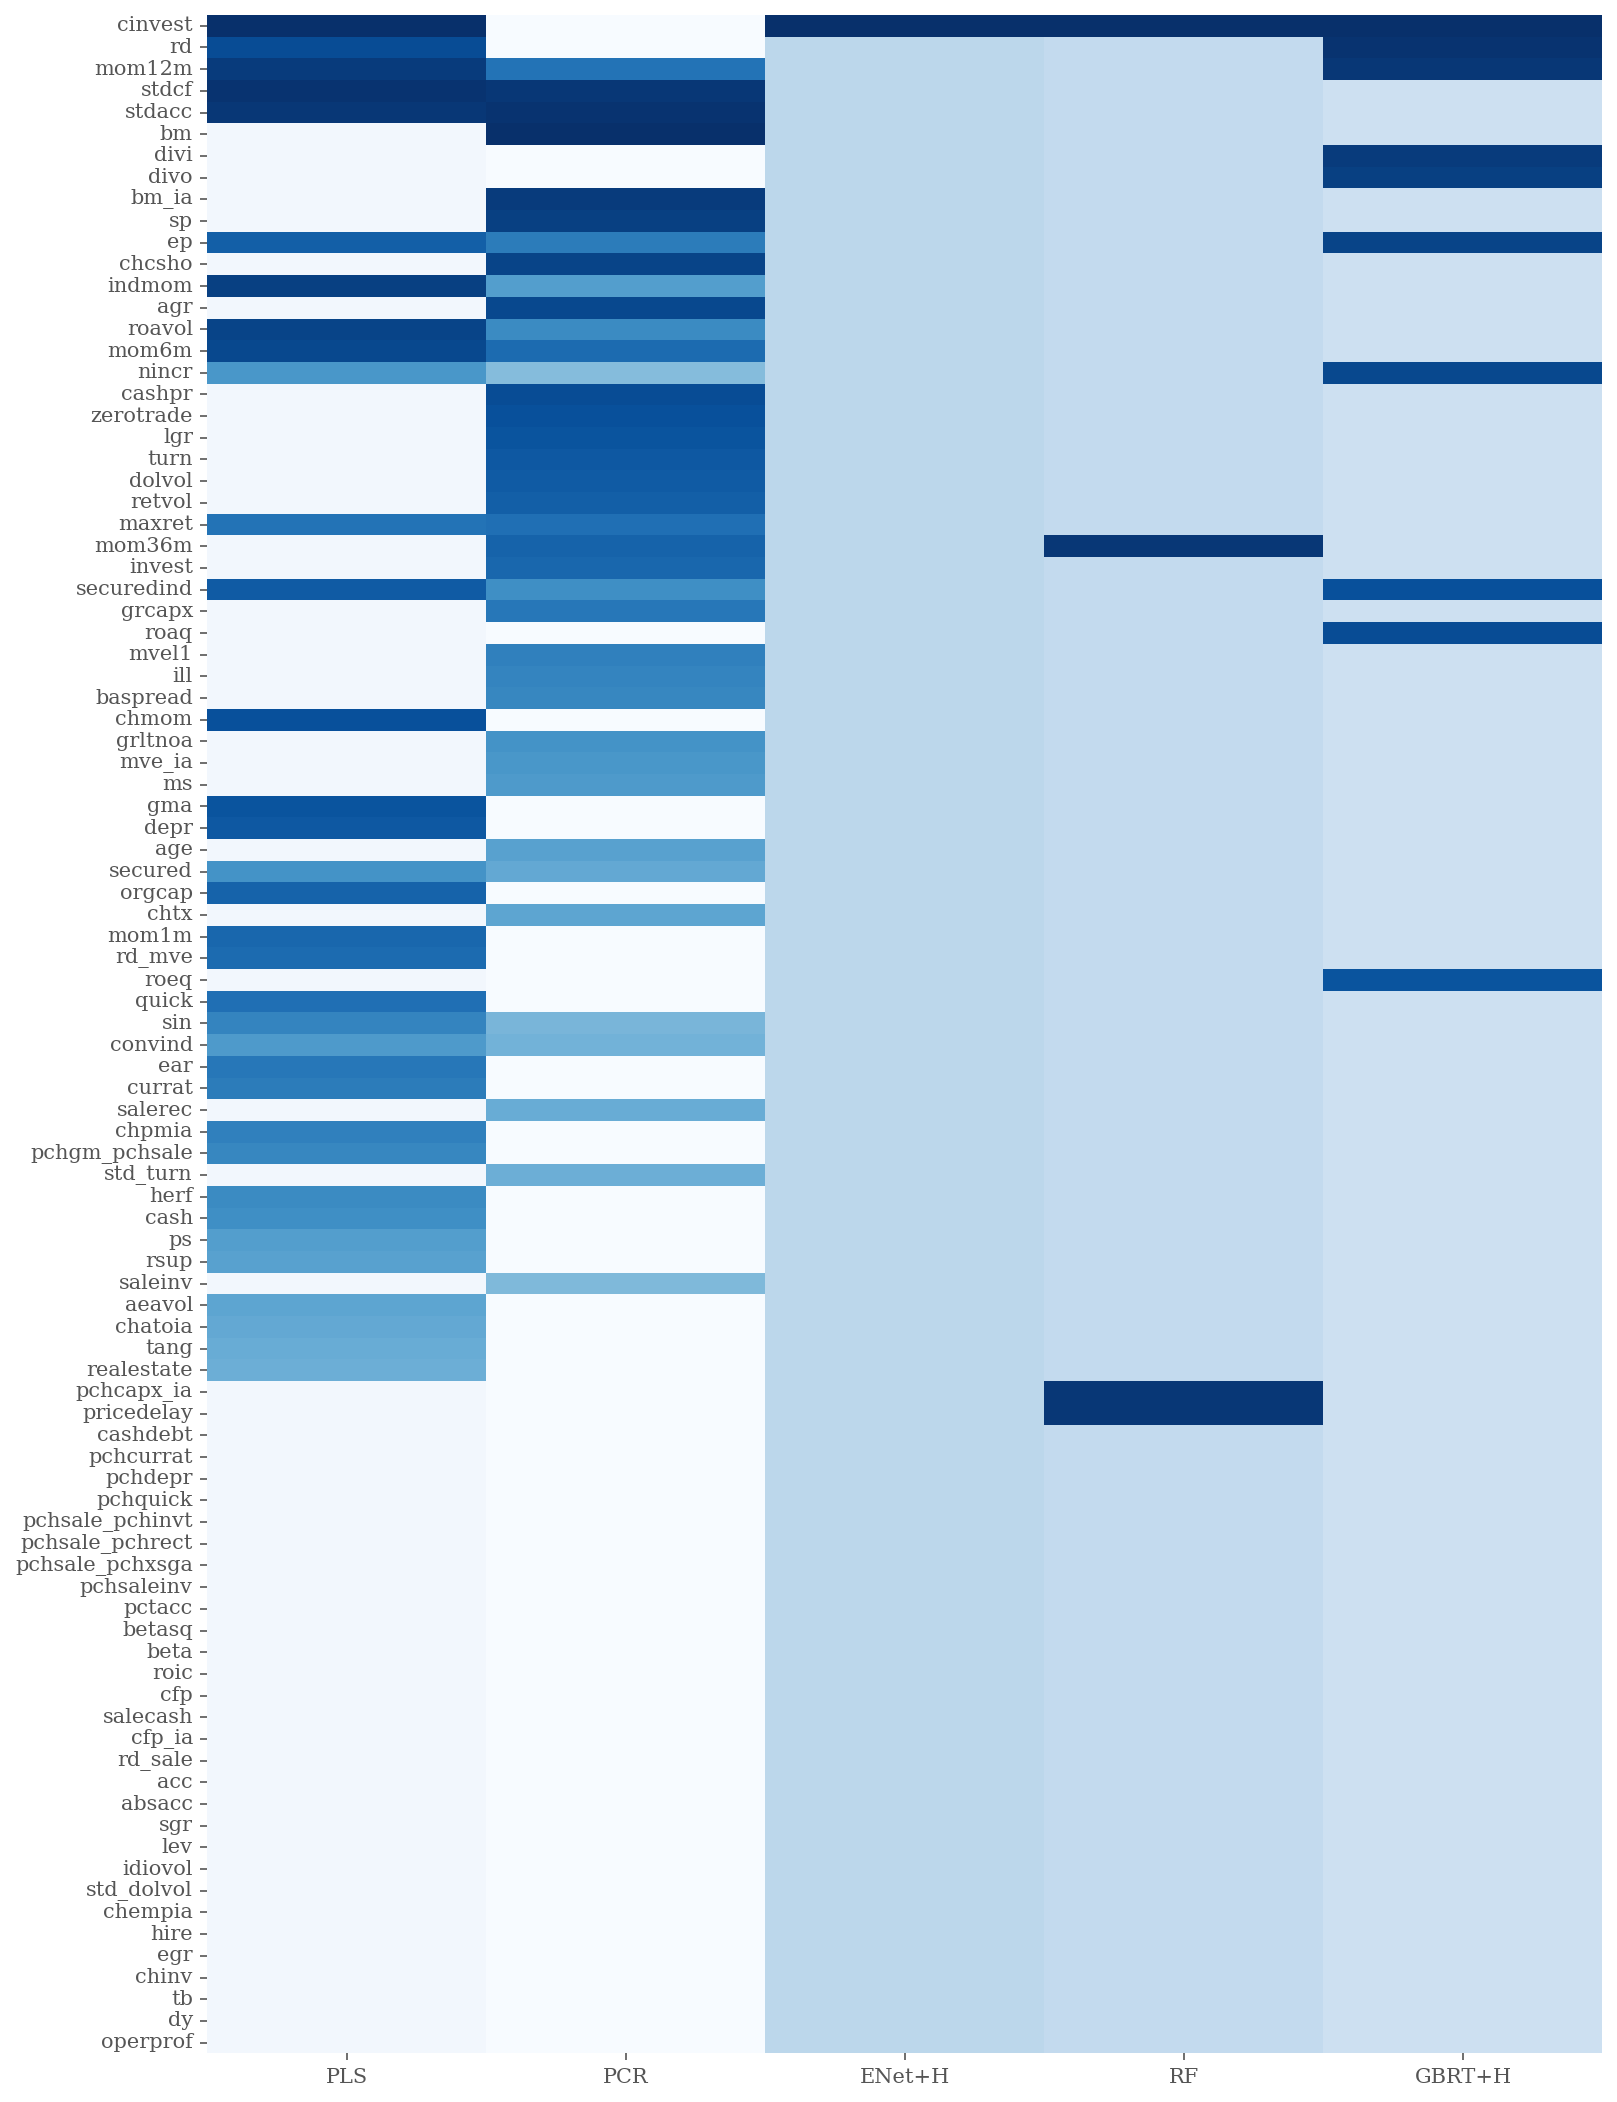

In [337]:
plt.figure(figsize=(12, 18), dpi=150)
ax = sns.heatmap(charac_rank.loc[character_names[idx]], cmap='Blues', cbar=False)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig('heatmap.pdf', format='pdf')
plt.show()

In [ ]:
plt.figure(figsize=(12, 18), dpi=150)
ax = sns.heatmap(charac_rank.loc[character_names[idx]].iloc[:20,:], cmap='Blues', cbar=False)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig('heatmap.pdf', format='pdf')
plt.show()

In [210]:
macro_df = pd.DataFrame()
# model_res_name
for name_idx, file in enumerate(result_file):
    vi_data = pd.read_csv(file, header=None)
    vi = np.sum(vi_data, axis=0)[94:].values
    vi[vi<0] = 0
    vi = vi/sum(vi)
    macro_df[model_name[name_idx]] = vi

In [214]:
macro_df.round(2)

,PLS,PCR,ENet+H,RF,GBRT+H
0,0.15,0.32,0.64,0.34,0.36
1,0.00,0.13,0.00,0.00,0.04
2,0.00,0.09,0.00,0.00,0.01
3,0.20,0.05,0.00,0.00,0.07
4,0.28,0.00,0.00,0.00,0.13
5,0.21,0.07,0.36,0.00,0.02
6,0.16,0.32,0.00,0.66,0.32
7,0.00,0.03,0.00,0.00,0.04


In [235]:
# performance_name = ['All', 'Top', 'Bottom']
# put together all portfolios
df_dict = dict(    ratio=macro_df.values.flatten('F'),
                   method=np.concatenate([macropredictors_names]*len(model_name)),
                   portfolio=sum([len(macropredictors_names)*[name] for name in model_name], []))
df = pd.DataFrame(df_dict) 

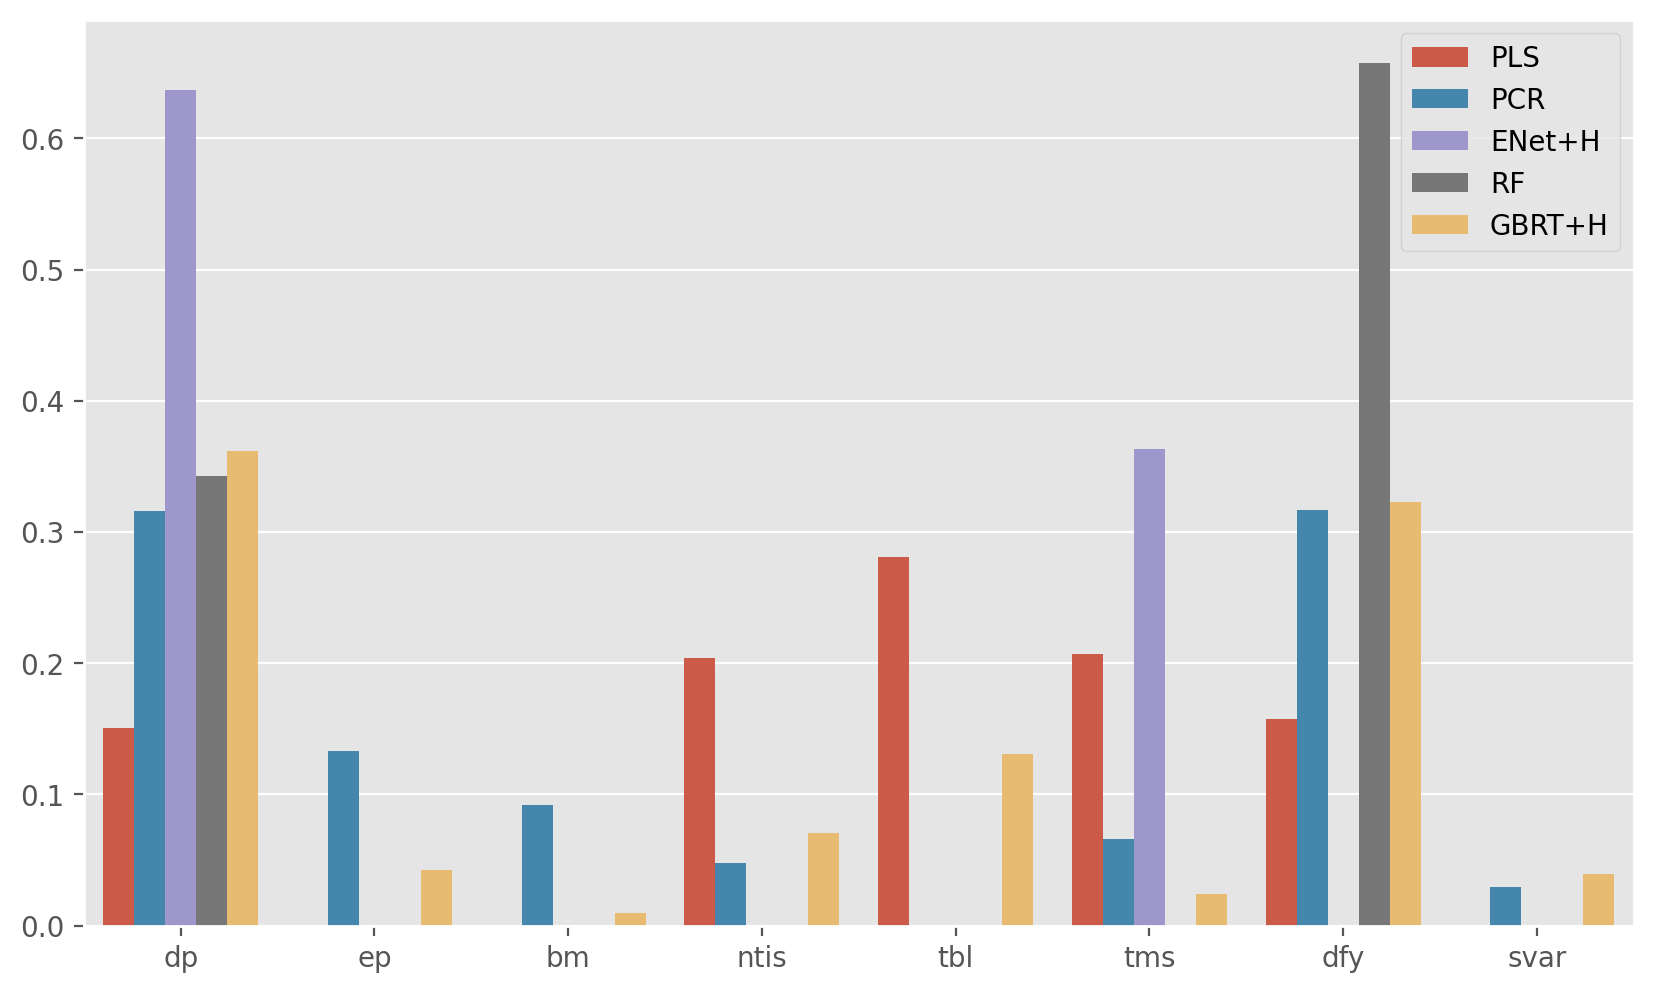

In [236]:
plt.figure(figsize=(10, 6), dpi=200)
ax=sns.barplot(x = 'method',
            y = 'ratio',
            hue = 'portfolio',
            data = df)
ax.set_ylabel("")#, fontsize = 20)
ax.set_xlabel("")
plt.legend(title='')
# Show the plot
plt.savefig('result_2.pdf', format='pdf')
plt.show()